# Face Alignment

This notebook experiments with models from [1], see https://www.adrianbulat.com/face-alignment for online overview.

### Load images 

Images are from LS3D-W dataset from [1].

In [1]:
import os
import math
import time
import cv2
import numpy as np

In [2]:
import matplotlib.pyplot as plt

In [3]:
from skimage import io, transform, draw

In [4]:
import glob

In [5]:
paths = sorted(glob.glob('data_faces/*.jpg'))

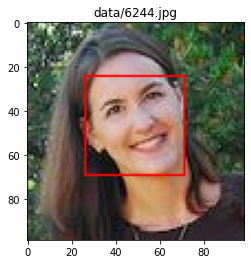

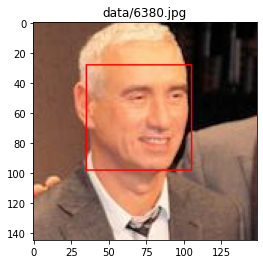

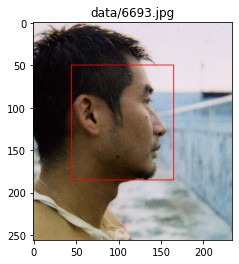

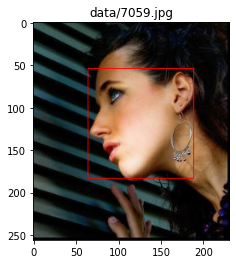

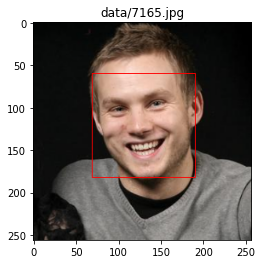

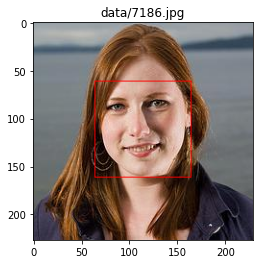

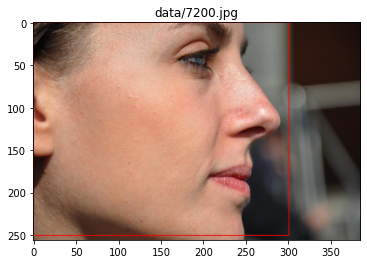

In [6]:
imgs = []
# ground truth bboxes
faces = [
    np.array([[26, 24 , 71, 69]]),
    np.array([[ 35,  28, 105,  98]]),
    np.array([[ 45,  50, 165, 185]]),
    np.array([[ 64,  54, 188, 183 ]]),
    np.array([[ 69,  60, 190, 182]]),
    np.array([[ 64.5173378 ,  61.36397934, 164.59318542, 161.4397583]]),
    np.array([[ 0,  0, 300 , 250]])]

for path, face in zip(paths, faces):
    face = face[0].astype(int)
    img = cv2.imread(path)
    if img.shape[0] > 256:
        scale = 256 / img.shape[0]
        img = cv2.resize(img, (int(img.shape[1]*scale), int(img.shape[0]*scale)))
    
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    imgs.append(img.copy())

    cv2.rectangle(img, tuple(face[:2]), tuple(face[2:]), (255,0,0))
    
    plt.figure()
    plt.title(path)
    plt.imshow(img)

### Face Alignment

In [7]:
import face_alignment

In [8]:
fa = face_alignment.FaceAlignment(face_alignment.LandmarksType._2D, flip_input=False, face_detector='blazeface')

In [9]:
def plot_dets(img, preds, highlight=False):
    plt.figure()
    plt.imshow(img)
    if not preds: return
    
    if not highlight:
        for detection in preds:
            plt.scatter(detection[:,0], detection[:,1], s=5)
    else:
        for detection in preds:
            plt.scatter(detection[:,0], detection[:,1], s=2, c='tab:blue')

            left_eye = np.mean(detection[36:42], axis=0)
            right_eye = np.mean(detection[42:48], axis=0)
            nose = np.mean(detection[30:36], axis=0)
            mouth = np.mean(detection[48:68], axis=0)

            s = 20
            plt.scatter(left_eye[0], left_eye[1], s=s, c='tab:olive')
            plt.scatter(right_eye[0], right_eye[1], s=s, c='tab:cyan')
            plt.scatter(nose[0], nose[1], s=s, c='orange')
            plt.scatter(mouth[0], mouth[1], s=s, c='red')

In [10]:
def plot_save(filename):
    plt.axis('off')
    plt.savefig(f"{filename}.png", bbox_inches='tight')

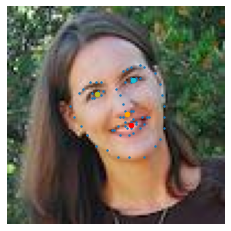

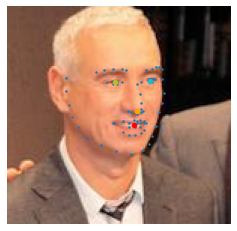

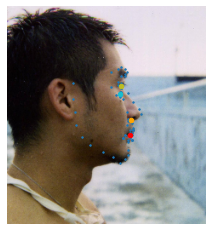

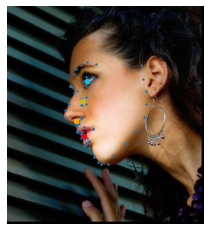

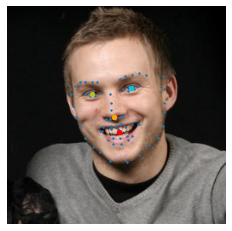

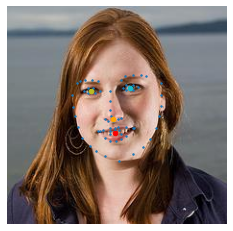

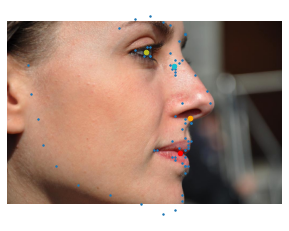

In [29]:
i = 0
for im, face in zip(imgs, faces):
    preds = fa.get_landmarks_from_image(im, detected_faces=face)
    plot_dets(im, preds, True)
#     plot_save(f'face_align_{i}')
    i += 1

### Performance

In [12]:
import face_alignment

In [13]:
fa2D = face_alignment.FaceAlignment(face_alignment.LandmarksType._2D, flip_input=False)
fa3D = face_alignment.FaceAlignment(face_alignment.LandmarksType._3D, flip_input=False)

#### Single

In [14]:
i = 0
img = imgs[i]
face = faces[i]

In [20]:
import torch.utils.benchmark as benchmark

In [25]:
t0 = benchmark.Timer(
    stmt='fa2D.get_landmarks_from_image(img, face)',
#     setup='from __main__ import fa2D',
    globals={'fa2D': fa2D, 'img': img, 'face': face})

t1 = benchmark.Timer(
    stmt='fa3D.get_landmarks_from_image(img, face)',
#     setup='from __main__ import fa3D',
    globals={'fa3D': fa3D, 'img': img, 'face': face})

print(t0.timeit(20))
print(t1.timeit(20))

fa2D.get_landmarks_from_image(img, face)
  87.35 ms
  1 measurement, 20 runs , 1 thread
fa3D.get_landmarks_from_image(img, face)
  168.37 ms
  1 measurement, 20 runs , 1 thread


#### Multiple

In [26]:
def evaluate_all_2d():
    for im, face in zip(imgs, faces):
        fa2D.get_landmarks_from_image(im, detected_faces=face)
        
def evaluate_all_3d():
    for im, face in zip(imgs, faces):
        fa3D.get_landmarks_from_image(im, detected_faces=face)

In [27]:
t0 = benchmark.Timer(
    stmt='evaluate_all_2d()',
    setup='from __main__ import evaluate_all_2d',
)

t1 = benchmark.Timer(
    stmt='evaluate_all_3d()',
    setup='from __main__ import evaluate_all_3d',
)

print(t0.timeit(10))
print(t1.timeit(10))

evaluate_all_2d()
  605.70 ms
  1 measurement, 10 runs , 1 thread
evaluate_all_3d()
  1.21 s
  1 measurement, 10 runs , 1 thread


### References

- [1] Bulat A, Tzimiropoulos G. How far are we from solving the 2d & 3d face alignment problem?(and a dataset of 230,000 3d facial landmarks). InProceedings of the IEEE International Conference on Computer Vision 2017 (pp. 1021-1030).